# import libraries

In [1]:
import os
import skimage.io
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import zipfile
import json
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay ,roc_curve, auc , accuracy_score , classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# helpful function

In [2]:
# display some images from the dataset

def draw_func(list_of_imgs, list_of_labels):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    # setting values to rows and column variables
    rows, columns = 3, 3

    # Separate fake and real images based on labels
    fake_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'fake' or 'fake1' or 'fake2' or 'fake3' or 'fake4'or 'fake5'  ]
    real_images = [img for img, label in zip(list_of_imgs, list_of_labels) if label == 'real' or 'real1'or 'real2'or 'real3'or 'real4'or 'real5']

    # Randomly select fake and real images with appropriate sample sizes
    fake_sample_size = min(5, len(fake_images))  # Adjust sample size if fewer than 5 fake images
    real_sample_size = min(4, len(real_images))  # Adjust sample size if fewer than 4 real images
    fake_sample = random.sample(fake_images, fake_sample_size)
    real_sample = random.sample(real_images, real_sample_size)

    # Combine the selected images and labels
    sample_images = fake_sample + real_sample
    sample_labels = ['fake'] * fake_sample_size + ['real'] * real_sample_size

    # Iterate over the selected images and labels
    for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
        # Adds a subplot at the i+1 position
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)  # Set the title as the corresponding label

    plt.tight_layout()
    plt.show()

In [3]:
# Define a learning rate schedule
def lr_schedule(epoch):
    lr = 1e-4 * (0.95 ** epoch)  # Reduce the learning rate by 5% every epoch
    return lr

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [4]:
# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

In [5]:
# function for evaluate the modl on test data
threshold = 0.5
def evaluate_test(model):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test , y_test, verbose=0)
    y_test_pred = model.predict(x_test)
    threshold = 0.5
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    # Generate a classification report
    report = classification_report(y_test, y_test_pred_binary)

    # Print the classification report
    print("\n")
    print("Classification Report:")
    print(report)
    return test_loss, test_accuracy

In [6]:
# function for predict confusion matrix
def prediction_confmatrix(model):
    # Get the predicted labels for training, validation, and test sets
    y_train_pred = model.predict(x_train)
    y_val_pred  = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    threshold = 0.5
    y_train_pred_binary = (y_train_pred > threshold).astype(int)
    y_val_pred_binary = (y_val_pred > threshold).astype(int)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)


    # Compute the confusion matrix for training, validation, and test sets
    train_conf_matrix = confusion_matrix(y_train,y_train_pred_binary)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred_binary)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

        # Set up the plot with a blue color map
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)

    # Plot the confusion matrix for training set
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training Set')

    # Print the confusion matrix for training set
    print("Confusion Matrix - Training Set:")
    print(train_conf_matrix)

    # Plot the confusion matrix for validation set
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[1])
    axes[1].set(title='Confusion Matrix - Validation Set')

    # Print the confusion matrix for validation set
    print("Confusion Matrix - Validation Set:")
    print(val_conf_matrix)

    # Plot the confusion matrix for test set
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"],
                ax=axes[2])
    axes[2].set(title='Confusion Matrix - Test Set')

    # Print the confusion matrix for test set
    print("Confusion Matrix - Test Set:")
    print(test_conf_matrix)

    plt.show()

    return y_train_pred_binary ,y_val_pred_binary, y_test_pred_binary ,train_conf_matrix,val_conf_matrix,test_conf_matrix

In [7]:
# Function to load images and resize them to (128, 128, 3)
def load_images(folder_path, limit=5000):
    images = []
    file_names = os.listdir(folder_path)

    # Ensure we don't exceed the limit
    for i, file_name in enumerate(file_names):
        if i >= limit:
            break
        file_path = os.path.join(folder_path, file_name)
        image = skimage.io.imread(file_path)
        image = resize(image, (128, 128, 3), anti_aliasing=True)
        images.append(image)

    return images

# load dataset

In [8]:
#define path and folders inside it
train_p ='E:\\New folder (6)\\New folder\\train'
test_p ='E:\\New folder (6)\\New folder\\test'
val_p = 'E:\\New folder (6)\\New folder\\valid'
folders = [f for f in os.listdir(train_p)]
print("folders=", folders)

folders= ['fake', 'real']


train data

In [9]:
#load the train data and put it in dataframe
train = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(train_p, folder))
    train_df = pd.DataFrame({'image': images ,'label': folder})
    train = pd.concat([train_df,train], ignore_index=False)
# Shuffle the data in the DataFrame
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,"[[[0.36411710083090126, 0.47003769369728143, 0...",real
1,"[[[0.40739355214016437, 0.44660915518668565, 0...",fake
2,"[[[0.2059901560858638, 0.3981318980814993, 0.0...",fake
3,"[[[0.8269977341380369, 0.854448714530194, 0.88...",fake
4,"[[[0.9612400075901739, 0.9769262820999777, 0.9...",fake


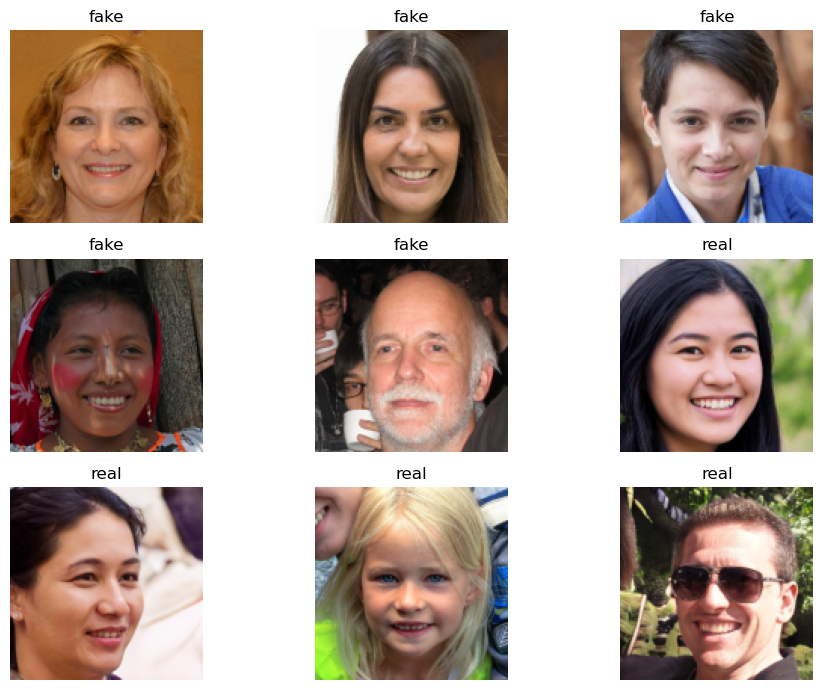

In [11]:
# show images sampels
draw_func(train['image'] ,train['label'])

test data

In [12]:
#load the test data and put it in dataframe
test = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(test_p, folder))
    test_df = pd.DataFrame({'image': images ,'label': folder})
    test = pd.concat([test_df,test], ignore_index=False)

# Shuffle the data in the DataFrame
test = test.sample(frac=1).reset_index(drop=True)
test


,image,label
0,"[[[0.6739731447343664, 0.6992755017977446, 0.6...",real
1,"[[[0.15991930923230055, 0.13288888714297428, 0...",fake
2,"[[[0.7437690647055755, 0.7286077952967852, 0.6...",real
3,"[[[0.7557173921261043, 0.6006271537201587, 0.3...",fake
4,"[[[0.034337879641509486, 0.038259448268960466,...",fake
...,...,...
9995,"[[[0.7563378232932735, 0.7524162546658226, 0.6...",fake
9996,"[[[0.5835858580052178, 0.4748689370887178, 0.2...",real
9997,"[[[0.7012162182032491, 0.7282099314830457, 0.5...",fake
9998,"[[[0.4074091243243869, 0.4086037373736711, 0.3...",fake


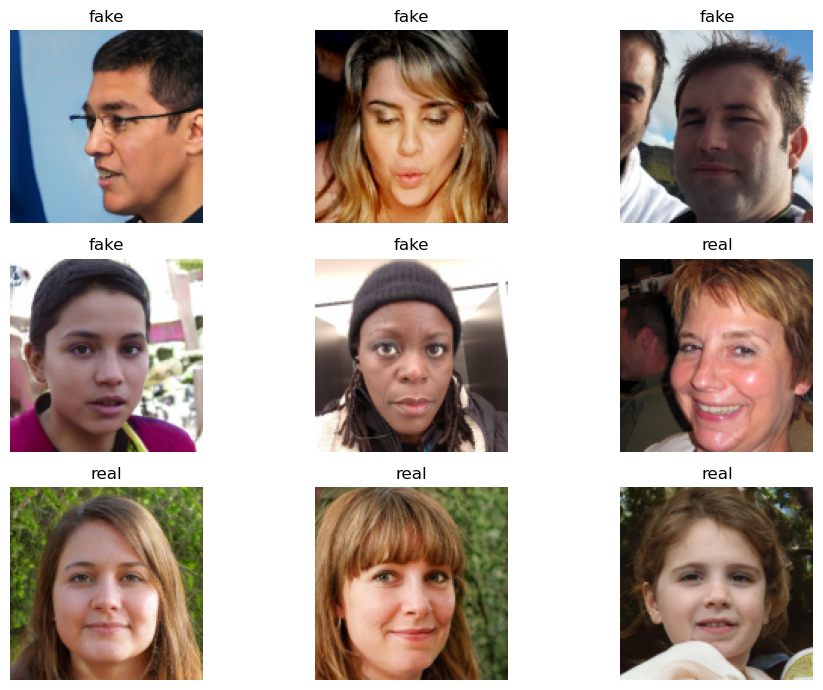

In [13]:
# show images sampels
draw_func(test['image'] ,test['label'])

validation data

In [14]:
#load the val data and put it in dataframe
val = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(val_p, folder))
    val_df = pd.DataFrame({'image': images ,'label': folder})
    val = pd.concat([val_df,val], ignore_index=False)

# Shuffle the data in the DataFrame
val = val.sample(frac=1).reset_index(drop=True)
val.head()

,image,label
0,"[[[0.24809959298635992, 0.2365689271811776, 0....",fake
1,"[[[0.09087123716426307, 0.08306335367309509, 0...",fake
2,"[[[0.007505578489460183, 0.031010970500633908,...",real
3,"[[[0.5248332115282682, 0.3524012998271641, 0.2...",fake
4,"[[[0.21338822720828754, 0.319480831626476, 0.2...",real


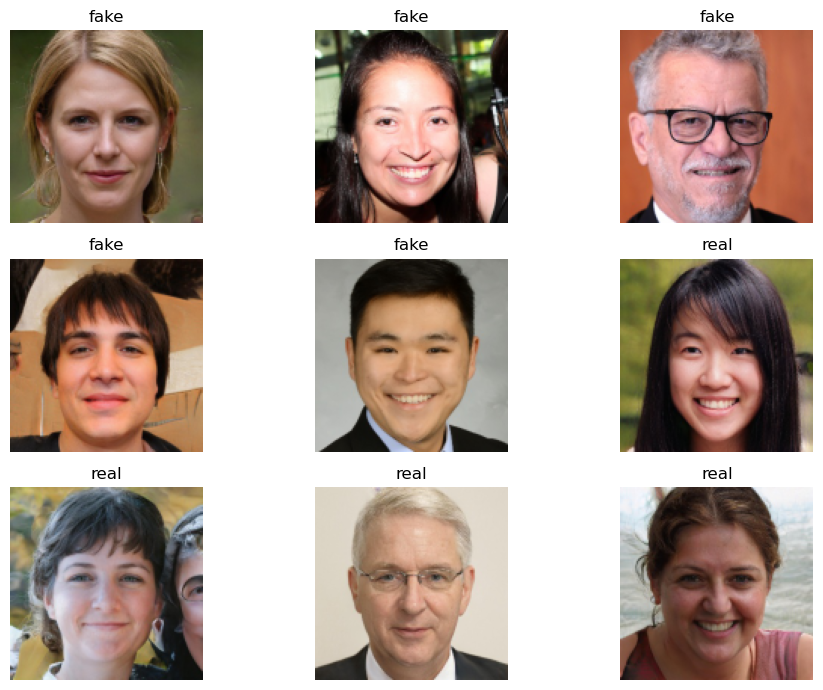

In [15]:
# show images sampels
draw_func(val['image'] ,val['label'])

# preprocess the data

In [16]:
#specify x for (train,val,test) then convert them to np.array to match the model
x_train = train['image']
x_val = val['image']
x_test = test['image']

x_train = np.stack(x_train.values)
x_val = np.stack(x_val.values)
x_test = np.stack(x_test.values)

In [17]:
x_train.shape , x_val.shape  , x_test.shape

((10000, 128, 128, 3), (10000, 128, 128, 3), (10000, 128, 128, 3))

In [18]:
#specify y for (train,val,test) then convert them to categorical to match the model
y_train = train['label']
y_val = val['label']
y_test = test['label']

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train= label_encoder.transform(y_train)

label_encoder.fit(y_val)
y_val= label_encoder.transform(y_val)

label_encoder.fit(y_test)
y_test= label_encoder.transform(y_test)

In [19]:
y_train.shape , y_val.shape  , y_test.shape

((10000,), (10000,), (10000,))

# models

In [20]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

**MobileNetV2**

In [21]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top (classification) layers
base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [22]:
# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 265s 410ms/step - loss: 0.4133 - accuracy: 0.8088 - val_loss: 2.3392 - val_accuracy: 0.5363
Epoch 2/20
625/625 [==============================] - 243s 389ms/step - loss: 0.1847 - accuracy: 0.9275 - val_loss: 2.2238 - val_accuracy: 0.5881
Epoch 3/20
625/625 [==============================] - 243s 389ms/step - loss: 0.1112 - accuracy: 0.9567 - val_loss: 0.8324 - val_accuracy: 0.7740
Epoch 4/20
625/625 [==============================] - 242s 387ms/step - loss: 0.0840 - accuracy: 0.9690 - val_loss: 0.3503 - val_accuracy: 0.8949
Epoch 5/20
625/625 [==============================] - 244s 390ms/step - loss: 0.0753 - accuracy: 0.9727 - val_loss: 0.4645 - val_accuracy: 0.8695
Epoch 6/20
625/625 [==============================] - 242s 387ms/step - loss: 0.0560 - accuracy: 0.9796 - val_loss: 0.4591 - val_accuracy: 0.8868
Epoch 7/20
625/625 [==============================] - 242s 387ms/step - loss: 0.0583 - accuracy: 0.9820 - val_loss: 0.2208 -

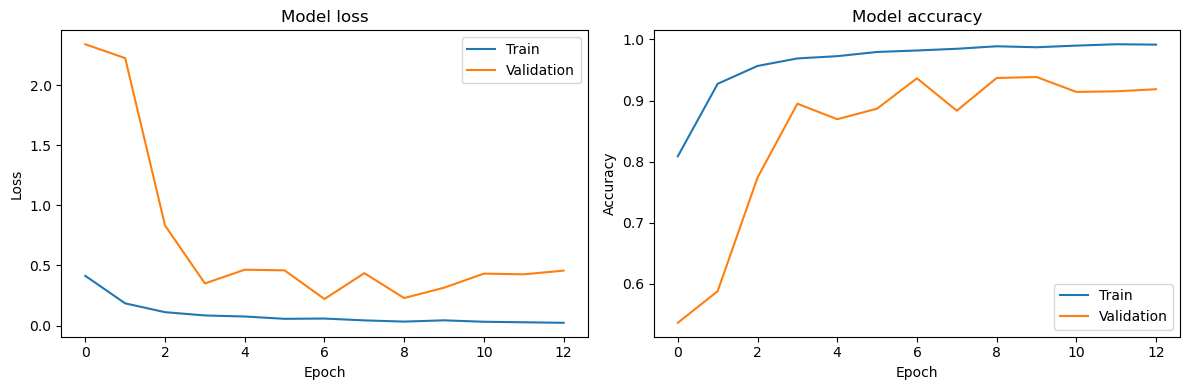

In [23]:
# Plot the learning curve
plot_learning_curve(history1)

In [24]:
# evaluate the model in test data
evaluation1=evaluate_test(model1)

313/313 [==============================] - 38s 119ms/step
Test Loss: 0.2182614952325821
Test Accuracy: 0.9366999864578247
Test Accuracy: 93.67%


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      5000
           1       0.92      0.95      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



313/313 [==============================] - 37s 118ms/step
Confusion Matrix - Training Set:
[[4961   39]
 [  16 4984]]
Confusion Matrix - Validation Set:
[[4565  435]
 [ 200 4800]]
Confusion Matrix - Test Set:
[[4594  406]
 [ 227 4773]]


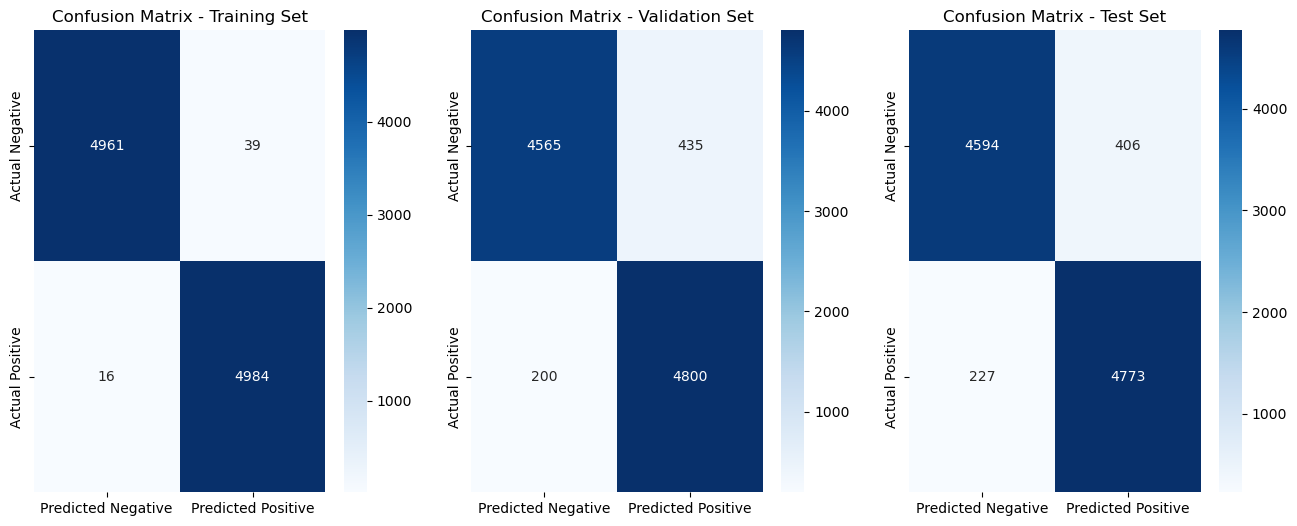

In [25]:
# predict values and confusion matrix
prediction1=prediction_confmatrix(model1)

 **Hyperprameter section for** **MobileNetV2**

increase batch size ,with constante learning rate 1e-4

In [26]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [27]:
# Load the MobileNetV2 model without the top (classification) layers
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [28]:

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
313/313 [==============================] - 198s 605ms/step - loss: 0.4167 - accuracy: 0.8042 - val_loss: 2.4892 - val_accuracy: 0.5164
Epoch 2/20
313/313 [==============================] - 197s 629ms/step - loss: 0.1468 - accuracy: 0.9429 - val_loss: 2.2865 - val_accuracy: 0.5543
Epoch 3/20
313/313 [==============================] - 197s 631ms/step - loss: 0.0594 - accuracy: 0.9801 - val_loss: 2.0094 - val_accuracy: 0.6543
Epoch 4/20
313/313 [==============================] - 197s 631ms/step - loss: 0.0504 - accuracy: 0.9829 - val_loss: 1.2158 - val_accuracy: 0.7300
Epoch 5/20
313/313 [==============================] - 197s 630ms/step - loss: 0.0480 - accuracy: 0.9833 - val_loss: 1.5768 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 198s 632ms/step - loss: 0.0361 - accuracy: 0.9878 - val_loss: 1.3780 - val_accuracy: 0.7756
Epoch 7/20
313/313 [==============================] - 198s 631ms/step - loss: 0.0332 - accuracy: 0.9875 - val_loss: 0.4647 -

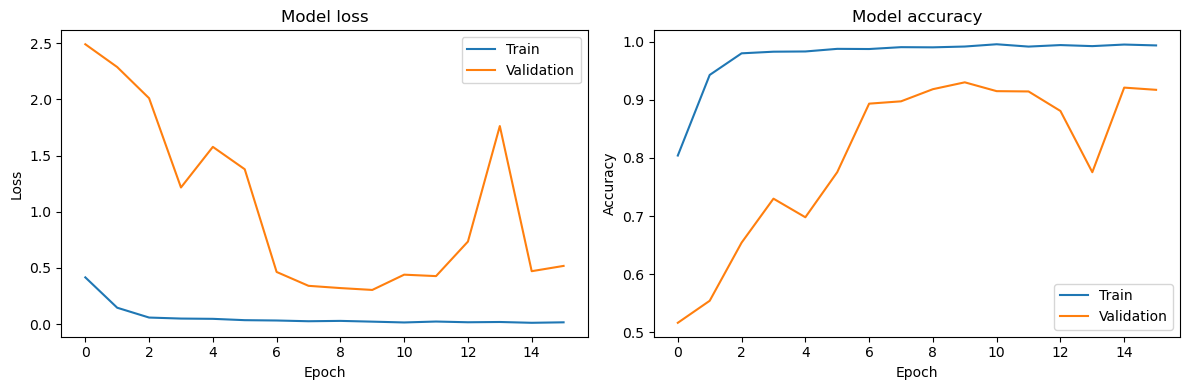

In [29]:
# Plot the learning curve
plot_learning_curve(history2)

In [30]:
# evaluate the model in test data
evaluation2=evaluate_test(model2)

313/313 [==============================] - 33s 103ms/step
Test Loss: 0.348560094833374
Test Accuracy: 0.9273999929428101
Test Accuracy: 92.74%


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      5000
           1       0.91      0.95      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



313/313 [==============================] - 37s 117ms/step
Confusion Matrix - Training Set:
[[4946   54]
 [   7 4993]]
Confusion Matrix - Validation Set:
[[4531  469]
 [ 229 4771]]
Confusion Matrix - Test Set:
[[4518  482]
 [ 244 4756]]


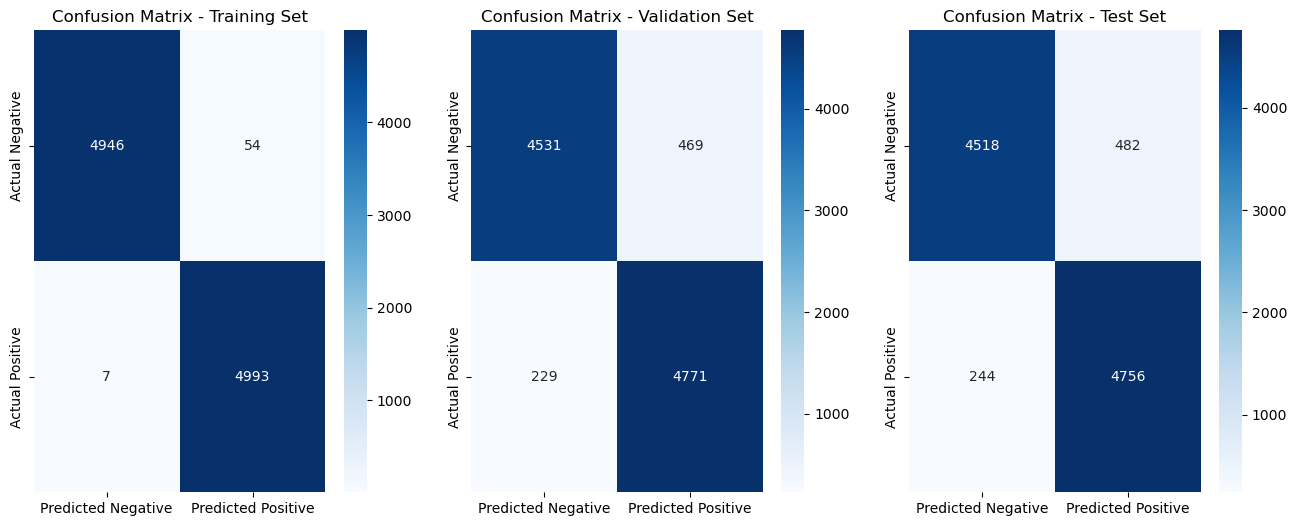

In [31]:
# predict values and confusion matrix
prediction2=prediction_confmatrix(model2)

decrease batch size ,with constante learning rate 1e-4

In [32]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [33]:
# Load the MobileNetV2 model without the top (classification) layers
base_model3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 2,552,065
Non-trainable params: 34,112
_________________________________________________________________


In [34]:

# Compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=8, callbacks=[early_stopping])


Epoch 1/20
1250/1250 [==============================] - 247s 190ms/step - loss: 0.4493 - accuracy: 0.7877 - val_loss: 1.1515 - val_accuracy: 0.6423
Epoch 2/20
1250/1250 [==============================] - 241s 193ms/step - loss: 0.2627 - accuracy: 0.8932 - val_loss: 0.3024 - val_accuracy: 0.8948
Epoch 3/20
1250/1250 [==============================] - 240s 192ms/step - loss: 0.1856 - accuracy: 0.9282 - val_loss: 0.9217 - val_accuracy: 0.7558
Epoch 4/20
1250/1250 [==============================] - 241s 193ms/step - loss: 0.1439 - accuracy: 0.9460 - val_loss: 0.1816 - val_accuracy: 0.9280
Epoch 5/20
1250/1250 [==============================] - 241s 193ms/step - loss: 0.1057 - accuracy: 0.9611 - val_loss: 0.1923 - val_accuracy: 0.9325
Epoch 6/20
1250/1250 [==============================] - 242s 194ms/step - loss: 0.0851 - accuracy: 0.9701 - val_loss: 0.1772 - val_accuracy: 0.9346
Epoch 7/20
1250/1250 [==============================] - 241s 193ms/step - loss: 0.0682 - accuracy: 0.9767 - val_

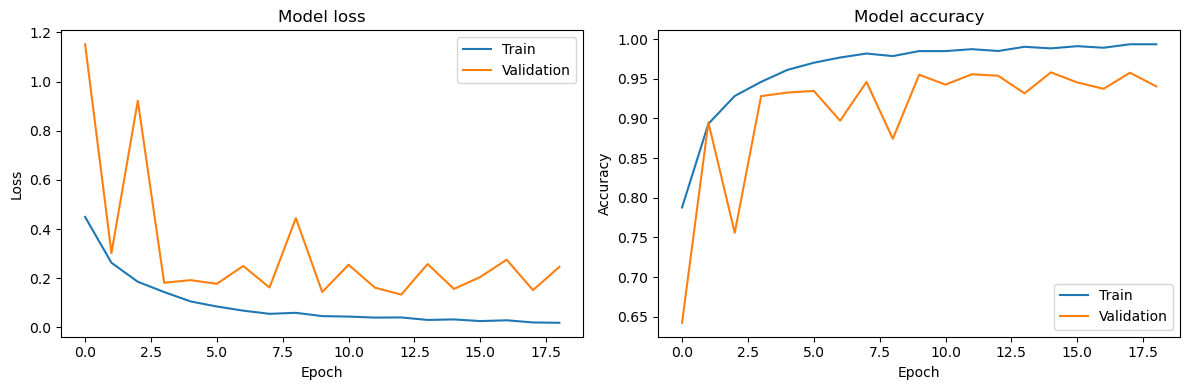

In [35]:
# Plot the learning curve
plot_learning_curve(history3)

In [36]:
# evaluate the model in test data
evaluation3=evaluate_test(model3)

313/313 [==============================] - 38s 119ms/step
Test Loss: 0.13282907009124756
Test Accuracy: 0.9573000073432922
Test Accuracy: 95.73%


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5000
           1       0.96      0.96      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



313/313 [==============================] - 33s 106ms/step
Confusion Matrix - Training Set:
[[4989   11]
 [  16 4984]]
Confusion Matrix - Validation Set:
[[4772  228]
 [ 235 4765]]
Confusion Matrix - Test Set:
[[4777  223]
 [ 204 4796]]


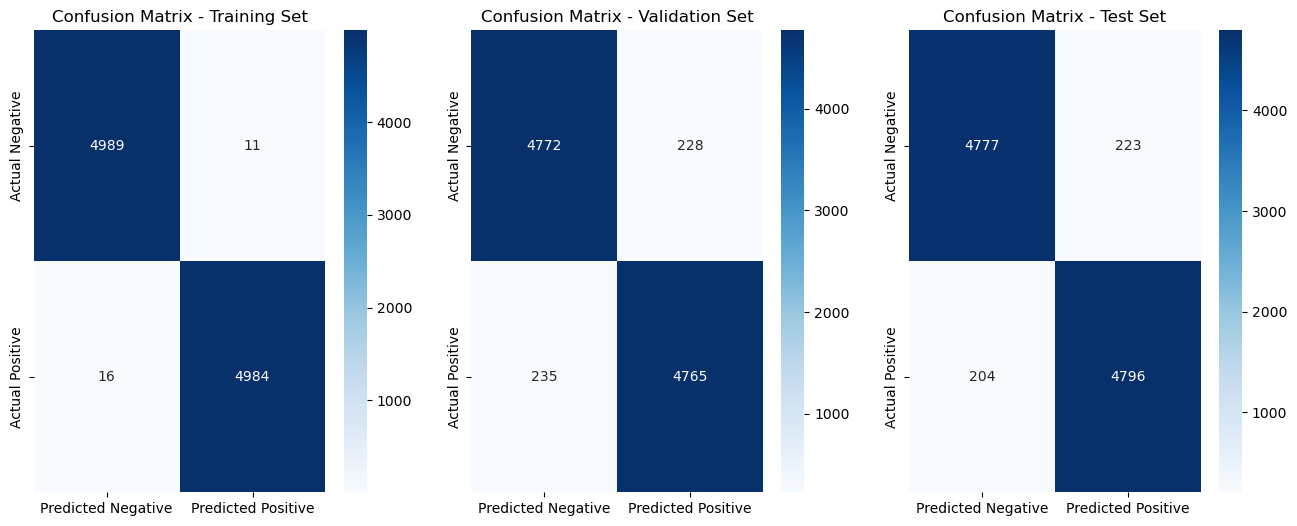

In [37]:
# predict values and confusion matrix
prediction3=prediction_confmatrix(model3)

# save model and load

In [40]:
# save whole model 
model3.save("model3")
model3.save("model3with.h5")

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


In [ ]:
# load the model 
#new_model=keras.models.load_model('model3with.h5')

In [43]:
#save only weights
model3.save_weights('model3weights.h5')

In [44]:
# load the model weights
model3.load_weights('model3weights.h5')

In [45]:
# evaluate the model in test data
evaluation3=evaluate_test(model3)

313/313 [==============================] - 40s 126ms/step
Test Loss: 0.13282907009124756
Test Accuracy: 0.9573000073432922
Test Accuracy: 95.73%


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5000
           1       0.96      0.96      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



 **increase epochs number**

In [46]:
# rerun the model to increase epochs number
# Compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history4 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=8, callbacks=[early_stopping])

Epoch 1/20
1250/1250 [==============================] - 587s 439ms/step - loss: 0.0418 - accuracy: 0.9865 - val_loss: 0.1582 - val_accuracy: 0.9462
Epoch 2/20
1250/1250 [==============================] - 541s 433ms/step - loss: 0.0316 - accuracy: 0.9904 - val_loss: 0.1938 - val_accuracy: 0.9485
Epoch 3/20
1250/1250 [==============================] - 544s 436ms/step - loss: 0.0294 - accuracy: 0.9904 - val_loss: 0.2054 - val_accuracy: 0.9261
Epoch 4/20
1250/1250 [==============================] - 535s 428ms/step - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.1936 - val_accuracy: 0.9383
Epoch 5/20
1250/1250 [==============================] - 537s 430ms/step - loss: 0.0246 - accuracy: 0.9935 - val_loss: 0.1909 - val_accuracy: 0.9467
Epoch 6/20
1250/1250 [==============================] - 544s 435ms/step - loss: 0.0218 - accuracy: 0.9935 - val_loss: 0.4677 - val_accuracy: 0.9115
Epoch 7/20
1250/1250 [==============================] - 536s 428ms/step - loss: 0.0187 - accuracy: 0.9933 - val_

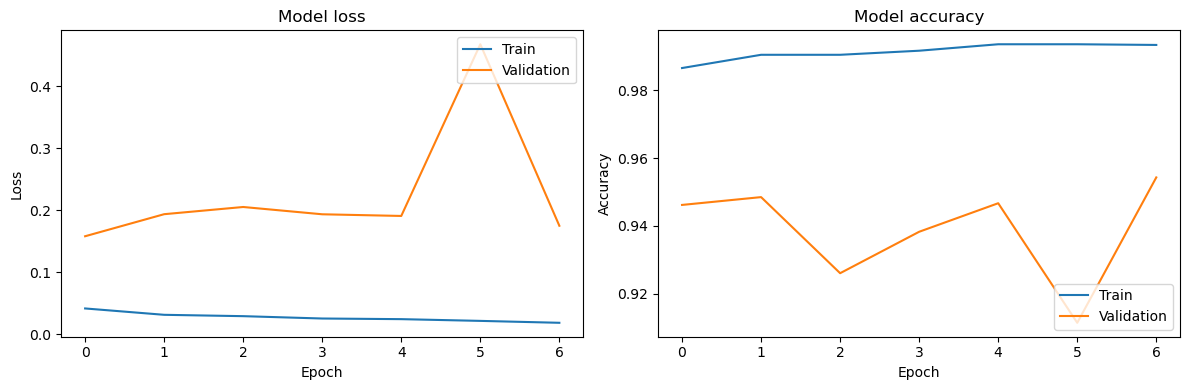

In [47]:
# Plot the learning curve
plot_learning_curve(history4)

In [48]:
# evaluate the model in test data
evaluation4=evaluate_test(model3)

313/313 [==============================] - 57s 179ms/step
Test Loss: 0.16673944890499115
Test Accuracy: 0.948199987411499
Test Accuracy: 94.82%


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5000
           1       0.96      0.93      0.95      5000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



313/313 [==============================] - 61s 193ms/step
Confusion Matrix - Training Set:
[[4995    5]
 [  50 4950]]
Confusion Matrix - Validation Set:
[[4834  166]
 [ 372 4628]]
Confusion Matrix - Test Set:
[[4821  179]
 [ 339 4661]]


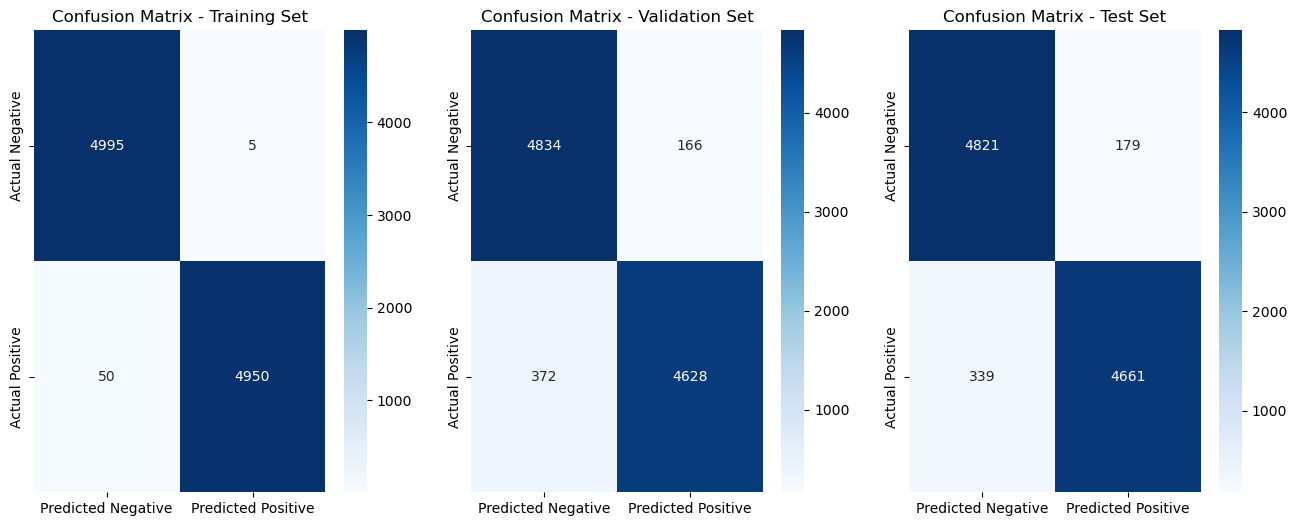

In [49]:
# predict values and confusion matrix
prediction4=prediction_confmatrix(model3)

comparison

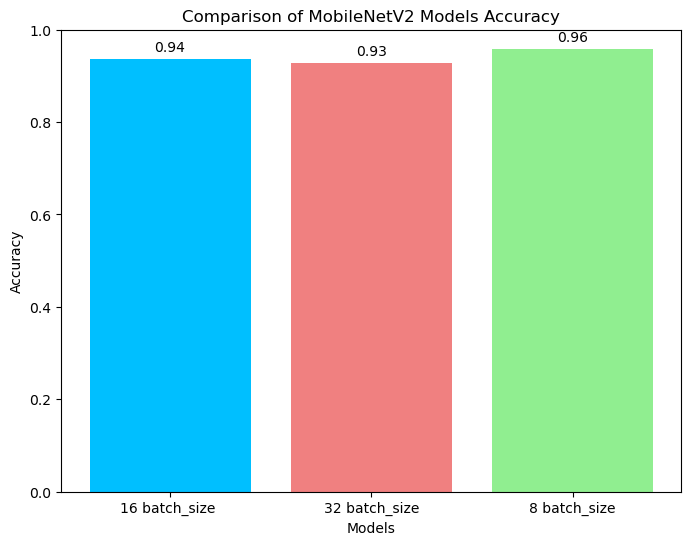

In [38]:

# Sample data for three models
models = ['16 batch_size ', '32 batch_size', '8 batch_size']
accuracy = [evaluation1[1],evaluation2[1],evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen' ])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of MobileNetV2 Models Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed

# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


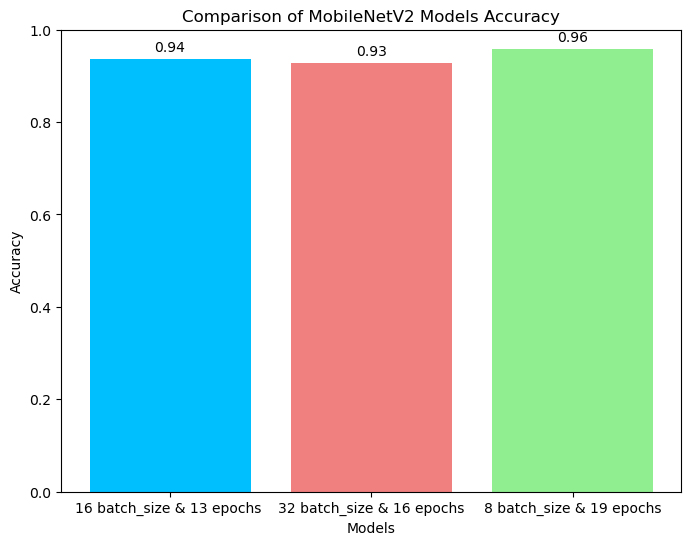

In [52]:

# Sample data for three models
models = ['16 batch_size & 13 epochs ', '32 batch_size & 16 epochs', '8 batch_size & 19 epochs']
accuracy = [evaluation1[1],evaluation2[1],evaluation3[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen' ])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of MobileNetV2 Models Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed

# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


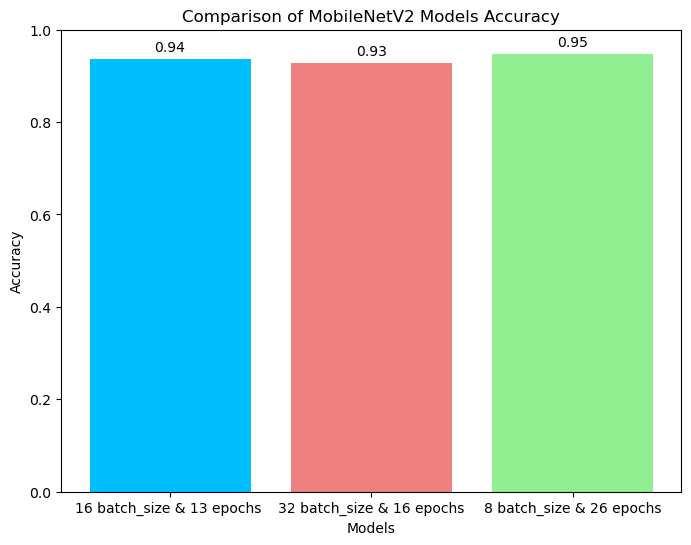

In [51]:
# Sample data for three models
models = ['16 batch_size & 13 epochs ', '32 batch_size & 16 epochs', '8 batch_size & 26 epochs']
accuracy = [evaluation1[1],evaluation2[1],evaluation4[1]]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['deepskyblue','lightcoral', 'lightgreen' ])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of MobileNetV2 Models Accuracy')
plt.ylim(0, 1)  # Set y-axis range if needed

# Display the values on top of the bars
for i, value in enumerate(accuracy):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()
